# Ames Housing Sale Price Predictions

In [1]:
#import all the Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

# Data import and cleaning

In [2]:
#reading out test data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df_test = pd.read_csv('../datasets/test.csv', keep_default_na=False)
df_train = pd.read_csv('../datasets/train.csv', keep_default_na=False)

## Train data cleaning

In [3]:
#replacing '' and 'None' with None
df_train = df_train.replace({'':None, 'None':None})

In [4]:
df_train.isnull().sum().head()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
dtype: int64

In [5]:
#converting supposed numeric from object to numeric for those with nulls we want to focus on
obj_to_num= ['Lot Frontage',   #list of objects that should be int
            'Mas Vnr Area',
            'BsmtFin SF 1',
            'BsmtFin SF 2',
            'Bsmt Unf SF',
            'Total Bsmt SF',
            'Bsmt Full Bath',
            'Bsmt Half Bath',
            'Garage Yr Blt',
            'Garage Area',
            'Garage Cars']

df_train['Lot Frontage'] = pd.to_numeric(df_train['Lot Frontage'], errors='ignore')
df_train['Mas Vnr Area'] = pd.to_numeric(df_train['Mas Vnr Area'], errors='ignore')
df_train['Garage Yr Blt'] = pd.to_numeric(df_train['Garage Yr Blt'], errors='ignore')

In [6]:
df_train['Central Air'] = (df_train['Central Air']== 'Y')*1 #masking and convert to binary

In [7]:
df_train.shape

(2051, 81)

In [8]:
df_train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [9]:
df_train.isnull().sum().sort_values(ascending=False).head(10)

Mas Vnr Type      1240
Lot Frontage       330
Garage Yr Blt      114
Mas Vnr Area        22
Bsmt Exposure        4
BsmtFin Type 2       2
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cond          1
Bsmt Cond            1
dtype: int64

### Null valued columns
Lot Frontage(int) = *16.09%*  
Mas Vnr Tpe(obj) = *60.45%*  - **can be dropped**   
Mas Vnr Area(int) = *1.07%*  
Garage Yr Blt(obj) = *5.55%*  
Garage Finish(obj) = 1  
Garage Cars(obj) = 1  
Garage Area(float) = 1  
Garage Qual(obj) = 1  
Garage Cond(obj) = 1  
Bsmt Full Bath(float) = 2  
Bsmt Half Bath(float) = 2  
Bsmt Qual(obj) = 1  
Bsmt Cond(obj) = 1  
Bsmt Exposure(obj) = 4  
BsmtFin Type 1(obj) = 1  
BsmtFin SF 1(float) = 1  
BsmtFin Type 2(obj) = 2  
BsmtFin SF 2(float) = 1  
Bsmt Unf SF(float) = 1  
Total Bsmt SF(float) = 1  

In [10]:
#drop the Mas Vnr Type column
df_train.drop(columns='Mas Vnr Type', inplace=True)

In [11]:
#replace Garage Yr Blt Null values with the mean
df_train['Garage Yr Blt'] = df_train['Garage Yr Blt'].replace({None:df_train['Garage Yr Blt'].mean()})

In [12]:
#replacing Lot Frontage Null values with the mean
df_train['Lot Frontage'] = df_train['Lot Frontage'].replace({None:df_train['Lot Frontage'].mean()})

In [13]:
#replace Mas Vnr Area Null values with the mean
df_train['Mas Vnr Area'] = df_train['Mas Vnr Area'].replace({None:df_train['Mas Vnr Area'].mean()})

In [14]:
# the rest with single digit null values are relatively negligible due to the scale of the data and as such shall just be dropped
df_train.dropna(inplace=True)

In [15]:
#converting the floats and obj to int, we dont want decimals
def convert_int(x):
    for i in x:
        df_train[x] = df_train[x].astype(int)
convert_int(obj_to_num)

In [16]:
df_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('int32')], dtype=object)

In [17]:
df_train.shape

(2044, 80)

## Test data cleaning

In [18]:
df_test.shape

(879, 80)

In [19]:
df_test.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [20]:
#replacing '' and 'None' with None
df_test = df_test.replace({'':None, 'None':None})

In [21]:
#changed type from object to float
df_test['Lot Frontage'] = pd.to_numeric(df_test['Lot Frontage'], errors='ignore') 
df_test['Garage Yr Blt'] = pd.to_numeric(df_test['Garage Yr Blt'], errors='ignore')

In [22]:
df_test['Central Air'] = (df_test['Central Air']== 'Y')*1 #masking and convert to binary

In [23]:
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,0,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NA,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,1,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NA,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,1,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,1,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,NA,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,1,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,NA,NA,NA,0,7,2009,WD


### Null valued columns
Lot Frontage(int) = *18.20%*  
Mas Vnr Tpe(obj) = *60.86%*  - **can be dropped**  
Electrical(obj) = *0.11%*   
Garage Finish(obj) =  *0.11%*   
Garage Yr Blt(obj) =  *5.11%*
   

In [24]:
#We cannot any rows in our test data as it will reduce the number of our predictions, making it unable to be submit to Kaggle.
df_test.shape

(879, 80)

In [25]:
df_test.isnull().sum().sort_values(ascending=False).head(10)

Mas Vnr Type      535
Lot Frontage      160
Garage Yr Blt      45
Mas Vnr Area        1
Garage Finish       1
Electrical          1
Sale Type           0
Year Remod/Add      0
Roof Style          0
Roof Matl           0
dtype: int64

69.00097847358121


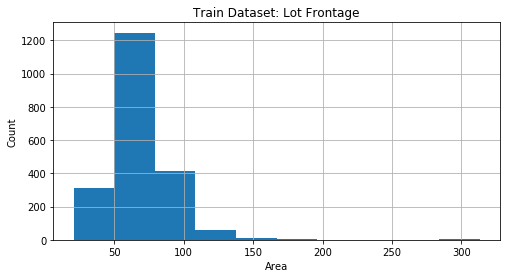

In [26]:
df_train['Lot Frontage'].hist(figsize=(8,4))
print(df_train['Lot Frontage'].mean())
plt.xlabel('Area')
plt.ylabel('Count')
plt.title('Train Dataset: Lot Frontage');

In [27]:
#replaced null values with Mean of Lot Frontage from Train data
df_test['Lot Frontage'] = df_test['Lot Frontage'].replace({None:df_train['Lot Frontage'].mean()})
df_test['Lot Frontage'] = df_test['Lot Frontage'].astype(int)  #we prefer int
df_test['Lot Frontage'].isnull().sum()

0

99.70401174168298


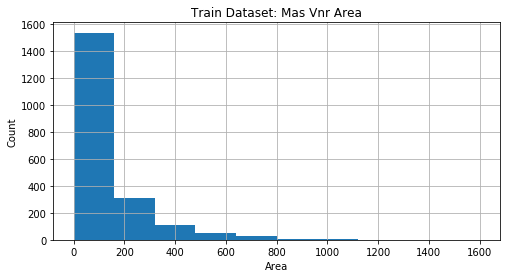

In [28]:
df_train['Mas Vnr Area'].hist(figsize=(8,4))
print(df_train['Mas Vnr Area'].mean())
plt.xlabel('Area')
plt.ylabel('Count')
plt.title('Train Dataset: Mas Vnr Area');

In [29]:
#replaced null values with Mean of Lot Frontage from Train data
df_test['Mas Vnr Area'] = df_test['Mas Vnr Area'].replace({None:df_train['Mas Vnr Area'].mean()})
df_test['Mas Vnr Area'] = df_test['Mas Vnr Area'].astype(int)  #we prefer int
df_test['Mas Vnr Area'].isnull().sum()

0

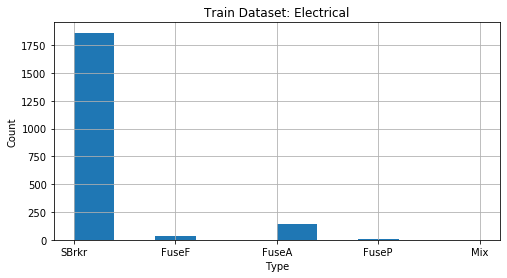

In [30]:
df_train['Electrical'].hist(figsize=(8,4))
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Train Dataset: Electrical');

In [31]:
#replaced null values with Mode of Lot Frontage from Train data
df_test['Electrical'] = df_test['Electrical'].replace({None:'SBrkr'})
df_test['Electrical'].isnull().sum()

0

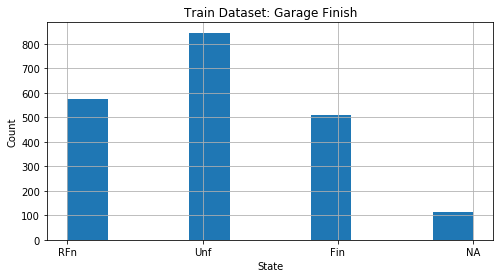

In [32]:
df_train['Garage Finish'].hist(figsize=(8,4))
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Train Dataset: Garage Finish');

In [33]:
#replaced null values with Mode of Lot Frontage from Train data
df_test['Garage Finish'] = df_test['Garage Finish'].replace({None:'Unf'})
df_test['Garage Finish'].isnull().sum()

0

In [34]:
# too many null values in 'Mas Vnr Type' and should be dropped
df_test = df_test.drop(columns = 'Mas Vnr Type')

In [35]:
df_train['Garage Yr Blt'].value_counts().head()

1978    146
2005    104
2007     83
2006     80
2004     72
Name: Garage Yr Blt, dtype: int64

In [36]:
#year 1978 is the most common date for garages to be built in train data therefore the null value shall hold this year.
df_test['Garage Yr Blt'] = df_test['Garage Yr Blt'].replace({None:'1978'})
df_test['Garage Yr Blt'] = df_test['Garage Yr Blt'].astype(int)  #we prefer int

In [37]:
df_comb = pd.concat([df_train, df_test], axis=0)
df_comb.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,69,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,289,Gd,TA,CBlock,TA,TA,No,GLQ,533,Unf,0,192,725,GasA,Ex,1,SBrkr,725,754,0,1479,0,0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976,RFn,2,475,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,3,2010,WD,130500.0


# Preprocessing

### Label encoding both our train and test data

In [38]:
#making a note of shape as we will be combining and splitting the data
df_train.shape 

(2044, 80)

In [39]:
df_test.shape

(879, 79)

In [40]:
#making note of the start and ends of both data sets to ensure we split them correctly
df_train.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,69,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,289,Gd,TA,CBlock,TA,TA,No,GLQ,533,Unf,0,192,725,GasA,Ex,1,SBrkr,725,754,0,1479,0,0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976,RFn,2,475,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,3,2010,WD,130500


In [41]:
df_test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,0,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,NA,Detchd,1910,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,69,9662,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,1,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,NA,Attchd,1977,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,NA,NA,NA,0,8,2006,WD


In [42]:
#combining train and test data so that when we label encode, 
#the numbers assigned to each category are uniform for both datasets
df_comb = pd.concat([df_train, df_test], axis=0)
df_comb.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,69,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,289,Gd,TA,CBlock,TA,TA,No,GLQ,533,Unf,0,192,725,GasA,Ex,1,SBrkr,725,754,0,1479,0,0,2,1,3,1,Gd,6,Typ,0,NA,Attchd,1976,RFn,2,475,TA,TA,Y,0,44,0,0,0,0,NA,NA,NA,0,3,2010,WD,130500.0


In [43]:
#identifying all our object typed columns
object_typed = df_comb.select_dtypes(include='object').columns.values.tolist()

In [44]:
#label encoding all object typed columns to churn numeric values and assigning it to a dataframe
label_encoded = df_comb[object_typed].apply(LabelEncoder().fit_transform)

In [45]:
#dropping all our object typed columns leaving only numeric columns
df_comb.drop(columns = object_typed, inplace=True)

In [46]:
#combining our new label encoded columns with the numeric columns
df_comb1 = pd.concat([df_comb,label_encoded], axis=1)

In [47]:
#splitting the now fully numeric train data
df_train_numeric = df_comb1[:2044]

In [48]:
#splitting the now fully numeric test data
df_test_numeric = df_comb1[2044:]

# EDA

In [49]:
#sieving through our object types columns to see if anything stands out
object_train = df_train.select_dtypes(include='object').columns.values.tolist()

In [50]:
len(object_train)

40

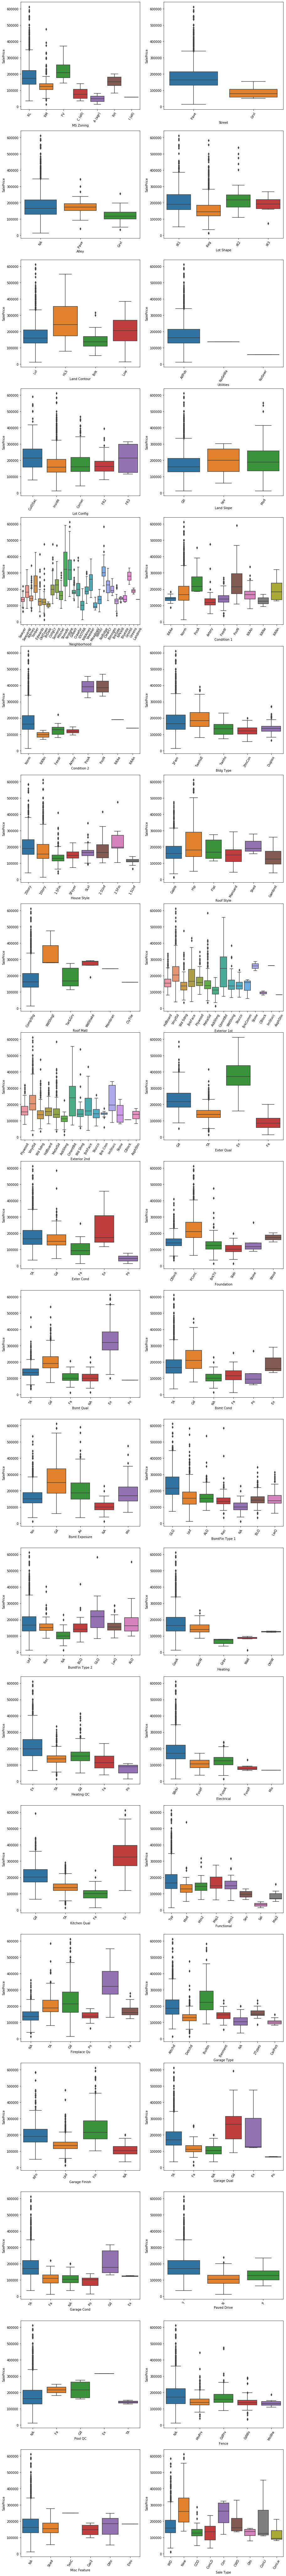

In [51]:
#creating boxplots for all our object typed columns against SalePrice
#This is to simply see if there are any columns that we do not want to include in our correlation matrix
#The numerical ones will be sieved out from the .corr function
fig, axes= plt.subplots(nrows=20, ncols=2, figsize=(15,150))
axes = axes.ravel()
for i, object_t in enumerate(object_train):
    box = sns.boxplot(x=object_t, y='SalePrice', data= df_train, ax= axes[i])
    x_ticks = df_train[object_t].unique()
    box.set_xticklabels(labels = x_ticks, rotation = 60 )

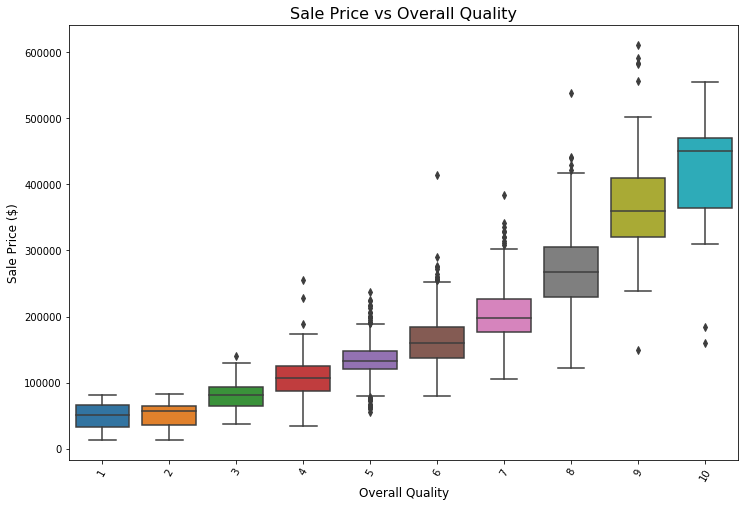

In [52]:
#for use in presentation slides
plt.figure(figsize=(12,8))  
box = sns.boxplot(x='Overall Qual', y='SalePrice', data= df_train)
x_ticks = range(1,11)
box.set_xticklabels(labels = x_ticks, rotation = 60 )
box.set_xlabel('Overall Quality', fontsize=12)
box.set_ylabel('Sale Price ($)', fontsize=12)
plt.title('Sale Price vs Overall Quality', fontsize=16);

### Observations
The vast majority properties hold a specific combination one would say.  
For example, Majority of Alleys are NA, Utilities are AllPub, Misc Features are NA, and Heating are GasA.  
Columns such as these, we do not want to include.
  
Some such as Neighborhood are quite peculiar with StoneBrridgHt and NoRidge seeming to be the more expensive Neighborhoods. Despite the majority of Condition 2 being Norm, PosA and PosN stand out quite a fair bit.
However, due to the majority being a specific category, these would generally hold less influence on the model we want to build.

Features such as MS Zoning, Neighborhood, Condition 2, Fireplace Qu, Bsmt Qual, Roof Mtl, External Qual, Exter Cond, and Street stand out quite a bit and should be considered.

In [53]:
#processing the entirely numerical dataset via .corr would be better than eyeballing boxplots

plus_not_bad_corr = (df_train_numeric.corr()['SalePrice'].sort_values())  # getting all the corr coeff for SalesPrice
plus_not_bad_corr = pd.DataFrame(plus_not_bad_corr)  #making it a dataframe
plus_4_corr = plus_not_bad_corr[plus_not_bad_corr.SalePrice>0.4].index.values.tolist() #extracting all that are > 0.4
minus_4_corr = plus_not_bad_corr[plus_not_bad_corr.SalePrice<-0.4].index.values.tolist() #extracting all that are <-0.4
not_bad_corr = plus_4_corr + minus_4_corr+ ['MS Zoning', 'Neighborhood', 'Condition 2', 'Fireplace Qu', 'Street', 'Roof Matl', 'Exter Cond']   #combining them into a list of quite 'influential' features

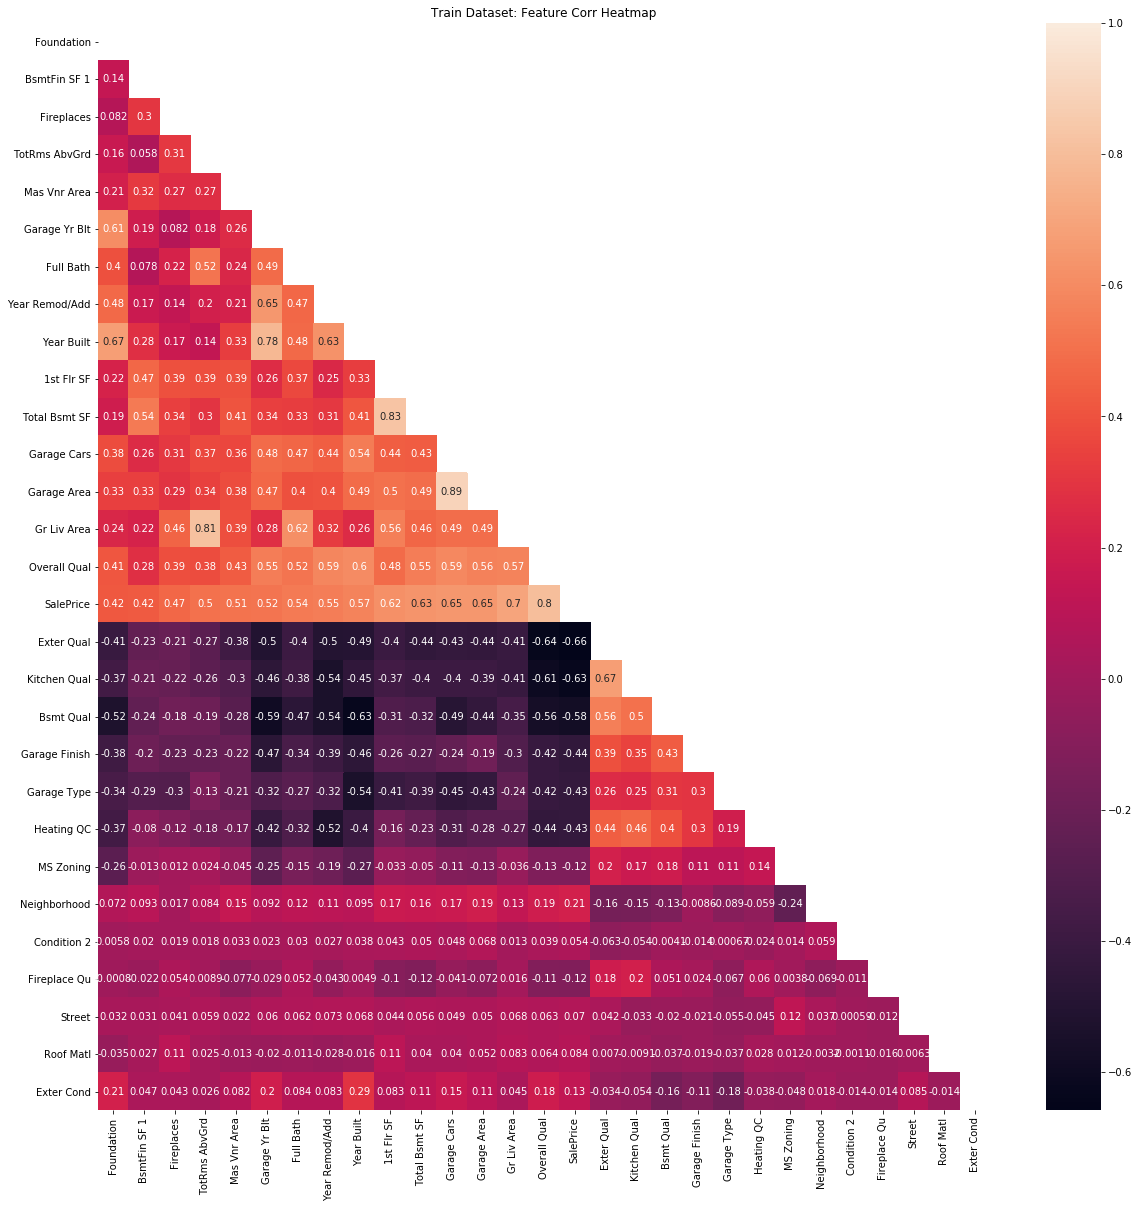

In [54]:
#plotting heatmap of the features >0.4 and <-0.4 on the Pearson correlation scale
plt.figure(figsize=(20,20))
mask = np.zeros_like(df_train_numeric[not_bad_corr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_train_numeric[not_bad_corr].corr(), annot = True, mask = mask)
plt.title('Train Dataset: Feature Corr Heatmap');

In [55]:
#since saleprice is our target, we take it out from our features
not_bad_corr.remove('SalePrice')

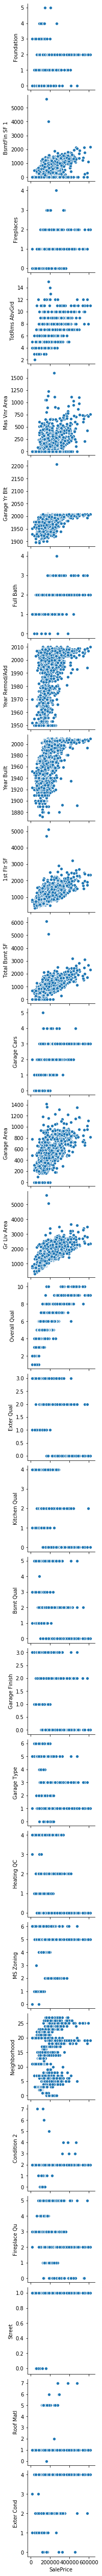

In [56]:
#creating a pairplot, However the numbers assigned to the categories are via alphabetical and not in a fixed sequence.
#Therefore, it will not abide by the scale given by the data dictionary.
#We did however combine our train and test to make sure both datastes are uniform in their label encoding.
sns.pairplot(df_train_numeric, y_vars=not_bad_corr, x_vars=['SalePrice']);

In [57]:
df_train_numeric.loc[df_train_numeric['Garage Yr Blt']>2150]#outlier found from pairplot

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type
1699,2261,916384070,20,68,8298,8,5,2006,2007,99,583,0,963,1546,1,1564,0,0,1564,0,0,2,0,2,1,6,1,2207,2,502,132,0,0,0,0,0,0,9,2007,267300.0,5,1,1,0,1,0,4,0,26,2,2,0,2,3,1,13,14,2,4,2,2,5,0,2,6,1,0,4,0,7,2,1,2,5,5,2,3,4,2,6


In [58]:
df_train_numeric.drop([1699], inplace=True)

C:\Users\fadhil\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


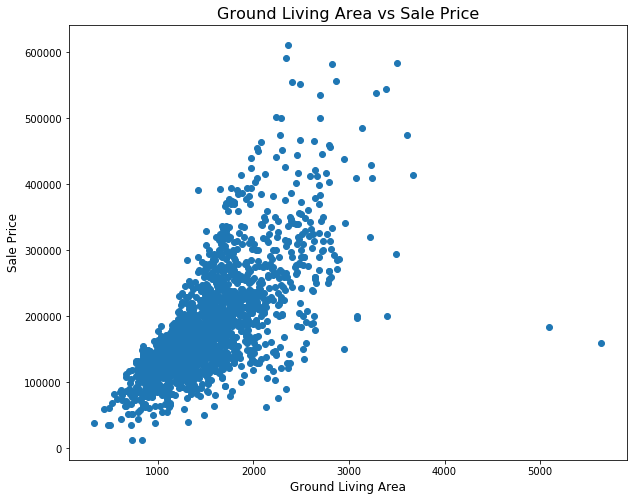

In [59]:
# for use in presentation slides
plt.figure(figsize=(10,8))  
box = plt.scatter(x='Gr Liv Area', y='SalePrice', data= df_train)
plt.xlabel('Ground Living Area', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.title('Ground Living Area vs Sale Price', fontsize=16);


# Modelling

In [60]:
#assignging our X and Y
features = not_bad_corr
X=df_train_numeric[features]
y=df_train_numeric['SalePrice']

In [61]:
#confirming they are the correct sizes
print(X.shape)
y.shape

(2043, 28)


(2043,)

In [62]:
#we do train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y)

In [63]:
#fitting the X_train
ss = StandardScaler()
ss.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [64]:
#scaling of x_train and x_test after fitting.
X_train_sc= ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [65]:
#Instantiate our models to see which is the best to use
lr= LinearRegression()
lasso= LassoCV(n_alphas = 300)
ridge = RidgeCV(alphas = np.linspace(0.1,10,300))

In [66]:
#cross validate our 3 models
lr_scores = cross_val_score(lr, X_train_sc, y_train).mean()
lasso_scores = cross_val_score(lasso, X_train_sc, y_train).mean()
ridge_scores = cross_val_score(ridge, X_train_sc, y_train).mean()

In [67]:
#cross validate our 3 models
lr_rmse = np.sqrt(-cross_val_score(lr, X_train_sc, y_train, scoring='neg_mean_squared_error').mean())
lasso_rmse = np.sqrt(-cross_val_score(lasso, X_train_sc, y_train, scoring='neg_mean_squared_error').mean())
ridge_rmse = np.sqrt(-cross_val_score(ridge, X_train_sc, y_train, scoring='neg_mean_squared_error').mean())

In [68]:
print(lr_scores)
print(lasso_scores)# we picked this as it has the best
print(ridge_scores)

0.7872390612365796
0.7804754138323585
0.7883358185369205


In [69]:
print(lr_rmse)
print(lasso_rmse)# we picked this as it has the best
print(ridge_rmse)

36839.537886275786
37433.495204472725
36740.46222423379


In [70]:
#fitting the train dataset to our model
lasso.fit(X_train_sc, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=300, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [71]:
lasso.score(X_train_sc, y_train) #train r^2

0.8211735790035172

In [72]:
lasso.score(X_test_sc, y_test)  #test r^2


0.8516274170114405

In [73]:
lasso_scores.mean() #Estimate of test r^2

0.7804754138323585

In [74]:
#acquire our predictions
predictions = lasso.predict(X_test_sc)

In [75]:
#acquire residuals
residuals = y_test-predictions

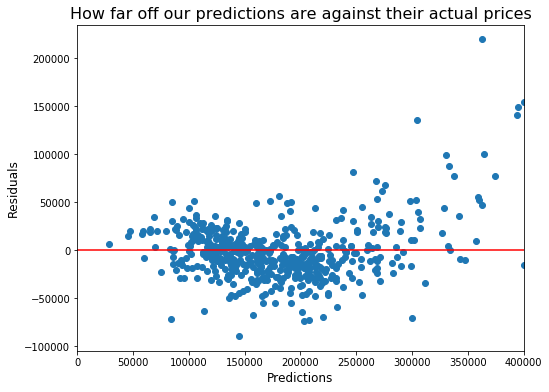

In [76]:
#seeing how our predictions fare against our residuals on a scatter plot
plt.figure(figsize=(8,6))
plt.scatter(predictions,residuals)
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('How far off our predictions are against their actual prices', fontsize=16)
plt.hlines(y=0, xmin=0, xmax=400000, color='r')
plt.xlim(0,400000);

In [77]:
#seeing the reduced features and the adjusted coefficiants
lasso.coef_

array([    0.        ,  7064.63978235,  6053.39205246,  1891.17522896,
        4362.75653061,     0.        ,     0.        ,  3562.15783298,
        2108.985166  ,  4336.87076924,  1655.27432681,  6380.62195489,
        4334.71029347, 15725.23189313, 20043.25635612, -7010.57299958,
       -7672.13184701, -3580.36418069, -1995.0793585 ,    -0.        ,
        -955.14224172,     0.        ,  1176.46949411,   570.90901209,
        -891.06960493,     0.        ,  1372.74406191,     0.        ])

In [78]:
#quick check on which ones were zeroed out
features

['Foundation',
 'BsmtFin SF 1',
 'Fireplaces',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Garage Yr Blt',
 'Full Bath',
 'Year Remod/Add',
 'Year Built',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Cars',
 'Garage Area',
 'Gr Liv Area',
 'Overall Qual',
 'Exter Qual',
 'Kitchen Qual',
 'Bsmt Qual',
 'Garage Finish',
 'Garage Type',
 'Heating QC',
 'MS Zoning',
 'Neighborhood',
 'Condition 2',
 'Fireplace Qu',
 'Street',
 'Roof Matl',
 'Exter Cond']

In [94]:
len(features)

28

In [79]:
#creating a dataframe to better visualise this
df_coef = pd.DataFrame(lasso.coef_, index = [features]) 

In [80]:
#tidying up the index
df_coef = df_coef.reset_index()

In [81]:
df_coef.columns = ['Features','Coefficient']

In [82]:
#dropping all the zeroed out features
df_coef.drop(df_coef[df_coef.Coefficient == 0].index, inplace=True)

In [83]:
#df_coef['Coefficient'] = df_coef['Coefficient'].abs()

In [96]:
#These are the biggest influencers
df_coef.sort_values(by='Coefficient', ascending =False).head()

,Features,Coefficient
14,Overall Qual,20043.256356
13,Gr Liv Area,15725.231893
16,Kitchen Qual,7672.131847
1,BsmtFin SF 1,7064.639782
15,Exter Qual,7010.573000


In [85]:
#creating a list of our reduced features
reduced_features = df_coef['Features'].values.tolist()

In [86]:
reduced_features

['BsmtFin SF 1',
 'Fireplaces',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Year Remod/Add',
 'Year Built',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Cars',
 'Garage Area',
 'Gr Liv Area',
 'Overall Qual',
 'Exter Qual',
 'Kitchen Qual',
 'Bsmt Qual',
 'Garage Finish',
 'Heating QC',
 'Neighborhood',
 'Condition 2',
 'Fireplace Qu',
 'Roof Matl']

In [95]:
len(reduced_features)

21

### Now we heave reduced features, we use this in our model

In [87]:
#assigning our x from testdata, with the reduced features
testdata_X = df_test_numeric[reduced_features]

In [88]:
#recreating our model with the reduced features
X = df_train_numeric[reduced_features]
y = df_train_numeric['SalePrice']
X_train, X_test, y_train, y_test =  train_test_split(X,y)
ss = StandardScaler()
ss.fit(X_train)
X_train_sc= ss.transform(X_train)
X_test_sc = ss.transform(X_test)

#we also need to scaled our x from test data with reference to the fit from x_train
testdata_X_sc= ss.transform(testdata_X)
lasso= LassoCV(n_alphas = 300)
lasso.fit(X_train_sc, y_train)

#finally using ou model on the test data
predictions = lasso.predict(testdata_X_sc)

In [89]:
#checking we're getting the same number of predictions
print(df_test_numeric.shape)
len(predictions)

(879, 80)


879

In [90]:
predictions

array([174474.76975594, 187830.00536073, 205522.07017617, 118088.54207412,
       192617.84594616,  85681.90754747,  92694.8863837 , 137290.37485756,
       203729.58126513, 170386.09573538, 176791.70333677, 117544.476755  ,
       148778.35497536, 284061.46125592, 149385.26347953, 121923.26917068,
       176795.53214163, 108167.73753447, 197025.20336018, 204221.65362019,
       128255.20491607, 126729.72222275, 214559.6257691 , 158035.13689151,
       193917.89760337, 101729.13288613, 127684.35603972, 145137.9194574 ,
       155315.76328253,  48750.30788407, 101954.71545647,  97892.20602577,
       249768.16730532, 172696.45818472, 219962.3001548 , 177872.68967262,
       131754.89039747,  99495.03657459, 109962.43560304, 200858.64564012,
       167247.15818959, 212716.54522318, 152877.71426745, 160854.9607641 ,
       249103.99549225,  91968.31722831, 227985.80948771, 109606.39384824,
       114180.22996946, 127514.87644226, 104278.38259783, 226373.95966245,
       257076.23558786, 1

In [91]:
#assigning the predicted SalePrice to our test dataframe
df_test_numeric['SalePrice'] = predictions

C:\Users\fadhil\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [92]:
#filtering to match the format required for submission to kaggle
answer = df_test_numeric[['Id','SalePrice']]

In [93]:
#saving it as a csv file to submit to kaggle
#answer.to_csv('../datasets/answer.csv', index = False)
#Score from submission to Kaggle: 31743.55421

# Conclusion and Recommendation:

After creating our model, the house prices generally rely on a specific set of features. The model however is generalised and will not accurately predict exceptions to the norm. Nonetheless, knowing the features will give a better estimate of a housing price and therefore provide better recommendations to those working with a budget.   
 <details>
<summary>The Features are as follows:  </summary>
    
    - Foundation   
    - BsmtFin SF 1   
    - Fireplaces   
    - Mas Vnr Area   
    - Year Remod/Add   
    - Year Built   
    - 1st Flr SF   
    - Total Bsmt SF   
    - Garage Cars   
    - Garage Area   
    - Gr Liv Area   
    - Overall Qual   
    - Exter Qual   
    - Kitchen Qual   
    - Bsmt Qual   
    - Garage Finish   
    - Heating QC   
    - Neighborhood   
    - Fireplace Qu   
    - Roof Matl   
 </details>
